### carico dipendenze

In [450]:
import argparse
import sys
from importlib import reload
from itertools import product
from pathlib import Path

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import yaml
from geopandas import points_from_xy
from matplotlib.colors import LogNorm, PowerNorm
from numpy.lib.stride_tricks import as_strided
from rasterio import CRS
from rasterio.transform import Affine, AffineTransformer
from scipy.signal import convolve2d
from skimage.color import rgb2gray
from skimage.registration import phase_cross_correlation
from tqdm import tqdm

try:
    from ot import (algoritmi, coreg, helpmsg, image_processing, interfaces,
                    main, metodi)
except ModuleNotFoundError:
    sys.path.append("../")
    from ot import (algoritmi, coreg, helpmsg, image_processing, interfaces,
                    main, metodi)

reload(image_processing)
reload(coreg)
reload(interfaces)
reload(metodi)
reload(algoritmi)


def get_corvara_dataset():
    path = "W:/SoLoMon/Siti/Corvara/DEM/" +\
        "LiDAR_HELICA_2019_2022/Elaborazioni_UNIMORE" +\
        "/IRIS_corvara_2022/Elaborazione_HSD_NCC"
    return dict(enumerate(Path(path).rglob("*.tif*")))


def get_output_dataset():
    path = "../output"
    return dict(enumerate(Path(path).rglob("*.tif*")))


# get_output_dataset()[1], get_output_dataset()[2]
# reference = get_output_dataset()[1]
# target = get_output_dataset()[2]
# ref = interfaces.Image.from_file(reference)
# tar = interfaces.Image.from_file(target)


def print_summary_statistics(array):
    print(f"\n{'<'*15}| STATS |{'>'*15}")
    print(f"              Mean: {np.mean(array): .3g}")
    print(f"            Median: {np.median(array): .3g}")
    print(f"Standard Deviation: {np.std(array): .3g}")
    print(f"           Minimum: {np.min(array): .3g}")
    print(f"           Maximum: {np.max(array): .3g}")
    print(f"   25th Percentile: {np.percentile(array, 25): .3g}")
    print(f"   75th Percentile: {np.percentile(array, 75): .3g}")


def numpy_to_cv2(img: interfaces.Image):
    if img.image.ndim == 3:
        return cv2.merge([cv2.cvtColor(img.image[e, :, :], cv2.COLOR_RGB2RGBA) for e in range(img.image.shape[0])])
    if img.image.ndim == 2:
        return cv2.cvtColor(img.image, cv2.COLOR_GRAY2RGBA)


def get_jpg_images():
    return dict(enumerate(Path("C:\\Users\\vcritell\\Pictures\\").glob("*.jpg")))


def get_png_images():
    return dict(enumerate(Path("C:\\Users\\vcritell\\Pictures\\").glob("*.png")))


def normalize_default(array):
    return cv2.normalize(array, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [451]:
class Image:
    """Class representing an image with multiple bands."""
    _image = None
    _affine = None
    _crs = None
    _nodata = None

    def __init__(self, image: np.ndarray, affine: Affine,
                 crs: CRS, nodata: int | float = None):
        """
        Initialize an Image instance.

        :param image: The image array.
        :param affine: The affine transformation matrix.
        :param crs: The coordinate reference system.
        :param nodata: The nodata value.
        """
        self.image = image
        splitted = cv2.split(image)
        self.bandnames = self.__get_bandnames(len(splitted))

        for bandname, band_array in zip(self.bandnames, splitted):
            setattr(self, bandname, band_array)

        self.affine = affine
        self.crs = crs
        self.nodata = nodata

    def __new__(cls, image, affine, crs, nodata=None):
        obj = super().__new__(cls)
        obj.image = image
        obj.affine = affine
        obj.crs = crs
        obj.nodata = nodata
        return obj

    def __repr__(self): return f"{self.image}\n{self.affine}\n{self.crs}"
    def __len__(self): return self.count
    
    def __iter__(self):
        for band in self.bandnames:
            yield self.__getattribute__(band)
        
    def __getitem__(self, __index):
        name = list(self.bandnames)[__index]
        return self.__getattribute__(name)
    
    @classmethod
    def __get_bandnames(cls, n): return tuple(f"B{i+1}" for i in range(n))

    @property
    def nodata(self): return self._nodata

    @nodata.setter
    def nodata(self, value): self._nodata = value

    @property
    def image(self): return self._image

    @image.setter
    def image(self, value): self._image = value

    @property
    def affine(self): return self._affine

    @affine.setter
    def affine(self, value): self._affine = value

    @property
    def crs(self): return self._crs

    @crs.setter
    def crs(self, value): self._crs = value

    @property
    def n_channels(self): return self.image.ndim

    @property
    def count(self):
        if self.n_channels == 2:
            return 1
        else:
            return self.image.shape[self.n_channels-1]

    @property
    def mask(self): return np.equal(self.image, self.nodata)

    @property
    def shape(self): return self.get_band(0).image.shape

    def split_channels(self):
        """Split the image into its individual channels."""
        imgs = list()

        for e in cv2.split(self.image):
            imgs.append(Image(e, self.affine, self.crs, self.nodata))

        return imgs

    def is_coregistered(self, __other) -> bool:
        """Check if the image is coregistered with another image."""
        assert all([self.affine is not None, __other.affine is not None])
        return self.affine == __other.affine


    def get_band(self, n: str | int | None = None):
        """Get a specific band from the image."""
        if n in self.bandnames:
            band = self.__getattribute__(n)
            return Image(band, self.affine, self.crs, self.nodata)
        
        elif isinstance(n, int):
            band = self[n]
            return Image(band, self.affine, self.crs, self.nodata)
        
        elif n is None:
            return self

    def _to_gdal(self, filename, driver: str = 'GTiff') -> None:
        """Save the image as a GDAL file."""
        height, width = self.shape

        with rasterio.open(filename, 'w', nodata=self.nodata,
                           transform=self.affine, width=width, height=height,
                           crs=self.crs, count=self.count, driver=driver,
                           dtype=self.image.dtype.__str__()) as ds:

            for n, band in enumerate(self):
                ds.write(band, n+1)

        print(filename, " saved.")

    def _to_image(self, filename) -> None:
        """Save the image as a standard image file."""
        raise NotImplementedError

    def to_file(self, filename) -> None:
        """Save the image to a file."""
        if all([self.affine, self.crs]):
            self._to_gdal(filename)
        else:
            self._to_image(filename)

    # def minmax_norm(self):
    #     """Normalize the image bands using min-max normalization."""
    #     bands = list()
    #     for band in self:
    #         bands.append(norm_minmax(band))

    #     return Image(cv2.merge(bands), self.affine, self.crs)

    # def zscore_norm(self):
    #     """Normalize the image bands using z-score normalization."""
    #     bands = list()
    #     for band in self:
    #         bands.append(norm_zscore(band))

    #     return Image(cv2.merge(bands), self.affine, self.crs)
    
    # def clahe(self):
    #     """Normalize the image bands using z-score normalization."""
    #     bands = list()
    #     for band in self:
    #         bands.append(clahe(band))

    #     return Image(cv2.merge(bands), self.affine, self.crs)

    # def log_norm(self):
    #     """Normalize the image bands using logarithmic transformation."""
    #     bands = list()
    #     for band in self:
    #         bands.append(norm_log(band))

    #     return Image(cv2.merge(bands), self.affine, self.crs)
    # # magari la elimino
    # def _normalize(self, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U):
    #     """Normalize the image using OpenCV normalization."""
    #     new_image = cv2.normalize(self.image, dst=None, alpha=alpha, beta=beta, norm_type=norm_type, dtype=dtype)
    #     return Image(new_image, self.affine, self.crs)

    # def to_single_band(self, coeff: list | np.ndarray | None = None, dtype: int | None = None):
    #     """Convert an RGB image to grayscale using specified coefficients."""
    #     '''
    #     Converte un'immagine RGB in scala di grigi utilizzando la formula:
    #     Y709 = 0.2125*R + 0.7154*G + 0.0721*B
    #     '''
    #     if not self.n_channels == 3:
    #         raise ValueError("Input image must be a 3D array")

    #     coeff = np.asarray(coeff) or np.array([0.21250, 0.71540, 0.07210])
    #     band = self.image[:, :, :3].dot(coeff)
    #     return Image(band, self.affine, self.crs, self.nodata)


### tests

In [7]:
def make_tests():
    dummy_affine = Affine(1, 0, 90.5, 0, -1, 0, 0, 0, 0)
    dummy_crs = CRS.from_epsg(32632)

    b1_int = interfaces.Image(np.random.randint(
        0, 255, (90, 130)), dummy_affine, crs=dummy_crs)

    b2_int = interfaces.Image(np.random.randint(
        0, 255, (90, 130, 2)), dummy_affine, crs=dummy_crs)
    b3_int = interfaces.Image(np.random.randint(
        0, 255, (90, 130, 3)), dummy_affine, crs=dummy_crs)

    b1_float = interfaces.Image(np.random.rand(
        90, 130), dummy_affine, crs=dummy_crs)
    b2_float = interfaces.Image(np.random.rand(
        90, 130, 2), dummy_affine, crs=dummy_crs)
    b3_float = interfaces.Image(np.random.rand(
        90, 130, 3), dummy_affine, crs=dummy_crs)

    test_arrays = [
        b1_int,
        # b2_int,
        b3_int,
        b1_float,
        # b2_float,
        b3_float
    ]

    test_names = [
        "b1_int",
        # "b2_int",
        "b3_int",
        "b1_float",
        # "b2_float",
        "b3_float"
    ]

    tests = dict(zip(test_names, test_arrays))
    methods = dict([
        (str(e).split(".")[1], e.value)
        for e in list(metodi.AlgFactory)
    ])

    parms = dict(
        [(e.stem, e)
        for e in Path.cwd().glob("*.yaml")
        ])

    print(tests.keys())

    return tests, methods, parms


def run_tests(tests, methods, parms):
    error_conf = list()
    for e in tests:
        img = tests[e]

        for m in methods:
            print(e, m)

            try:
                alg = methods[m].from_YAML(parms[m])
                alg(img, img)

            except Exception as error:
                print(f"ERRORE {m} {e}\n descr: {error}")
                error_conf.append((m, alg, img))


### eseguo tests

In [ ]:
run_tests(*make_tests())

### debug

In [287]:
def load_file(source: str,
              nodata: int | float | None = None,
              read_band: int | None = None) -> interfaces.Image:
    """
    Create an Image instance from a file.
    """
    assert Path(source).exists(), f"File {source} does not exist"
    assert Path(source).is_file(), f"File {source} is not a file"

    source = Path(source)
    suffix = source.suffix

    if (suffix in ['.tiff', '.tif']):
        with rasterio.open(str(source)) as src:

            bands = list()
            bandsindex = [read_band] or tuple(range(1, src.meta["count"] + 1))
            nodata = nodata or src.meta['nodata']

            for bandnum in bandsindex:
                band_array = src.read(bandnum)
                # band_array[band_array == nodata] = 0
                bands.append(band_array)

            if len(bands) == 1:
                image = image_processing.toCV8U(*bands)

            else:
                image = cv2.merge(bands)
                # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                image = cv2.normalize(image, dst=None,
                                      alpha=0, beta=255,
                                      norm_type=cv2.NORM_MINMAX,
                                      dtype=cv2.CV_8U)

        # nodata = 0
        affine = src.meta['transform']
        crs = src.meta['crs']

    elif suffix in ['.jpg', '.jpeg', '.png']:
        image = cv2.imread(str(source), cv2.IMREAD_COLOR)

        # nodata = None
        affine = None
        crs = None

    return interfaces.Image(image, affine, crs, nodata)

In [288]:
def np_to_cv2_dtype(array: np.ndarray) -> int:
    dtype_map = {
        'uint8': cv2.CV_8U,
        'int8': cv2.CV_8S,
        'uint16': cv2.CV_16U,
        'int16': cv2.CV_16S,
        'int32': cv2.CV_32S,
        'float32': cv2.CV_32F,
        'float64': cv2.CV_64F
    }
    return dtype_map.get(array.dtype.name, None)

In [369]:
def is_cv8u(array) -> bool:
    return np_to_cv2_dtype(array) == cv2.CV_8U

In [370]:
def is_multiband(array) -> bool: return array.ndim > 2

In [382]:
def np2cv(array):
    if not is_cv8u(array):
        array = image_processing.toCV8U(array)
    
    if is_multiband(array):
        array = cv2.cvtColor(array, cv2.COLOR_BGR2GRAY)
    
    return array

In [441]:
def load_raster(source: str, band: int | None = None) -> np.ndarray:
    """Convert a rasterio image to an 8-bit unsigned integer image using OpenCV."""

    with rasterio.open(source) as src:
        if band is None:
            iter_bands = range(src.count)
        else:
            iter_bands = [band]

        channels = []
        for b in iter_bands:
            band = src.read(b+1)
            band[band == src.meta['nodata']] = 0
            channels.append(band)

        # dataset = cv2.cvtColor(cv2.merge(channels), cv2.COLOR_RGB2BGR)
        dataset = cv2.merge(channels)
        affine = src.meta['transform']
        crs = src.meta['crs']
        
        return dataset, affine, crs

In [462]:
def load_file(source, **kwargs):
    source = Path(source)

    match source.suffix:
        case ".tif":
            dataset, affine, crs = load_raster(source, **kwargs)
        case ".tiff":
            dataset, affine, crs = load_raster(source, **kwargs)
        case ".jpg":
            dataset = cv2.imread(source)
            affine = None
            crs = None
        case ".jpeg":
            dataset = cv2.imread(source)
            affine = None
            crs = None
        case ".png":
            dataset = cv2.imread(source)
            affine = None
            crs = None
        
    return Image(dataset, affine, crs)

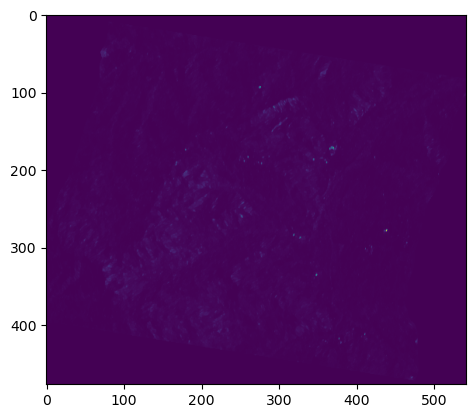

In [460]:
plt.imshow(load_file(a, band=1).image)

In [466]:
def cv2_clahe(array: np.ndarray, clip_limit: float = 2.,
              kernel_size: int | tuple[int] = 3,
              return_same: bool = False,
              same_range: bool = False) -> np.ndarray:
    """
    Contrast limited adaptive histogram equalization
    """
    array_dtype = np_to_cv2_dtype(array)

    if same_range:
        vmin, vmax = array.min(), array.max()
    else:
        vmin, vmax = .0, 1.

    if array_dtype != cv2.CV_8U:
        array = cv2.normalize(array,
                              dst=None, alpha=0, beta=255,
                              norm_type=cv2.NORM_MINMAX,
                              dtype=cv2.CV_8U)
    if array.ndim > 2:
        array = cv2.cvtColor(array, cv2.COLOR_BGR2GRAY)

    if isinstance(kernel_size, int):
        kernel_size = kernel_size, kernel_size

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=kernel_size)
    clahe_band = clahe.apply(array)

    if return_same:
        clahe_band = cv2.normalize(clahe_band,
                                   dst=None, alpha=vmin, beta=vmax,
                                   norm_type=cv2.NORM_MINMAX,
                                   dtype=array_dtype)

    return clahe_band

In [467]:
def cv2_minmax_norm(array, return_same: bool = True):
    """Min-Max values normalization based on OpenCV"""
    array_dtype = np_to_cv2_dtype(array)

    if array_dtype != cv2.CV_8U:
        array = cv2.normalize(array,
                              dst=None, alpha=0, beta=255,
                              norm_type=cv2.NORM_MINMAX,
                              dtype=cv2.CV_8U)
    if array.ndim > 2:
        array = cv2.cvtColor(array, cv2.COLOR_BGR2GRAY)

    array = cv2.equalizeHist(array)

    if return_same:
        array = cv2.normalize(array,
                              dst=None, alpha=0, beta=1,
                              norm_type=cv2.NORM_MINMAX,
                              dtype=array_dtype)
    
    return array


In [468]:
def cv2_log_norm(array: np.ndarray, epsilon=1e-2):
    """Normalize a band using logarithmic transformation."""

    array_dtype = np_to_cv2_dtype(array)

    if array_dtype == cv2.CV_8U and array.ndim > 2:
        array = cv2.cvtColor(array, cv2.COLOR_BGR2GRAY)

    if array_dtype not in [cv2.CV_16F, cv2.CV_32F]:
        array = cv2.normalize(array,
                              dst=None, alpha=0, beta=1,
                              norm_type=cv2.NORM_MINMAX,
                              dtype=cv2.CV_8U)

    normalized = np.log(array + epsilon)

    return normalized



In [469]:
def infer_nodata_mask(array: np.ndarray, use_max: bool = False) -> np.ndarray:
    vmin, vmax = np.percentile(array, [0.001, 99.999])

    if use_max:
        return array >= vmax
    else:
        return array <= vmin

In [470]:
def homogenize_nan(array, nodata, overwrite_nodata = None):
    array = array.copy()
    mask = (array == nodata).any(axis=2)
    new_nan = overwrite_nodata or nodata

    for i in range(array.shape[-1]):
        array[:, :, i][mask] = new_nan
    
    return array

In [471]:
def apply_mask(array, mask):
    return np.ma.masked_array(array, mask)

array([[[-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.]],

       [[-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.]],

       [[-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.]],

       ...,

       [[-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.]],

       [[-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        [-9999., -9999., -9999.],
        .

m.dtype = dtype('float32')
_m_5.dtype = dtype('float32')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.001243097..384.70438].


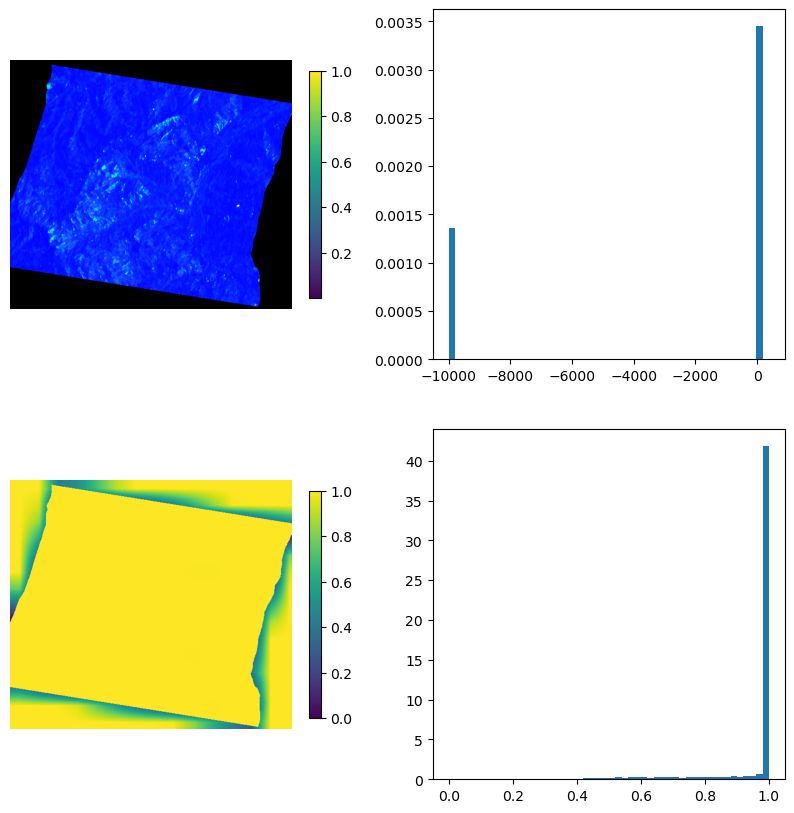

In [490]:
a, b = get_output_dataset()[1], get_output_dataset()[2]

m = load_file(a).image
m = homogenize_nan(m, -9999)
mask = infer_nodata_mask(m)#.any(axis=2)

# m = np.clip(m, a_min=0, a_max=m.max())
print(f"{m.dtype = }")
_m_5 = cv2_clahe(m, 560, 15, return_same=True)
print(f"{_m_5.dtype = }")
# _m_5 = norm_log(m, epsilon=1e-5)
# _m_5 = image_processing.cv2_clahe(_m_3, kernel_size=15, clip_limit=15)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.ravel()
ax1.axis('off')
# ax2.set_aspect(0.1)
ax3.axis('off')
# ax4.axis('off')

aximg1 = ax1.imshow(apply_mask(m, mask))
plt.colorbar(aximg1, ax=ax1, shrink=0.65)
_ = ax2.hist(m.ravel(), bins=50, density=True)

aximg3 = ax3.imshow(_m_5)
_ = ax4.hist(_m_5.ravel(), bins=50, density=True)
plt.colorbar(aximg3, ax=ax3, shrink=0.65)


In [486]:
_m_5

array([[17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17],
       ...,
       [17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17]], shape=(477, 541), dtype=uint8)

In [117]:
class Raster:
    _dataset = None
    _metadata = None

    def __init__(self, dataset, metadata):
        self.dataset = dataset
        self.metadata = metadata

    def __iter__(self):
        for band in range(self.count):
            yield self.dataset[band, :, :]

    def __len__(self): return self.count

    @property
    def dataset(self): return self._dataset

    @property
    def metadata(self): return self._metadata

    @dataset.setter
    def dataset(self, value): self._dataset = value

    @metadata.setter
    def metadata(self, value): self._metadata = value

    @property
    def dtype(self): return self.dataset.dtype

    @property
    def shape(self): return self.dataset.shape

    @property
    def count(self): return self.metadata['count']

    @property
    def nodata(self): return self.metadata['nodata']

    @property
    def epsg(self): return self.metadata['crs'].to_epsg()

    @staticmethod
    def read_gdal(filename):
        with rasterio.open(filename, "r") as ds:
            return Raster(ds.read(), ds.meta)